In [2]:
import pandas as pd

In [3]:
crime = pd.read_csv("crime_preprocessed_rf")

In [4]:
violent_crime_list = [3, 10, 27, 21, 17, 20, 22, 15]
violent_crime = crime[crime['UCRdesc_numeric'].isin(violent_crime_list)]
crime = violent_crime

In [6]:
crime['OffenseDate'] = pd.to_datetime(crime['OffenseDate'], errors='coerce')
# Step 2: Set 'OffenseDate' as the index
crime.set_index('OffenseDate', inplace=True)

In [7]:
# Step 3: Now group by 'CENSUS_TRACT' and resample using the 'OffenseDate' index
crime_time_series = crime.groupby(['CENSUS_TRACT', pd.Grouper(freq='W')]).agg({
    'DOW': 'mean',  
    'HourofDay': 'mean',
    'ExtractedMonth': 'mean',
    'ExtractedDay': 'mean',
}).reset_index()

# Step 4: Create the 'Crime_Count' feature based on size (count of crimes)
crime_time_series['Crime_Count_W'] = crime.groupby(['CENSUS_TRACT', pd.Grouper(freq='W')]).size().values

# Now the 'violent_crime_time_series' contains the aggregated features and 'Crime_Count'
crime_time_series

,CENSUS_TRACT,OffenseDate,DOW,HourofDay,ExtractedMonth,ExtractedDay,Crime_Count_W
0,Census Tract 1011.01,2018-01-07,2.000000,0.000000,1.0,1.000000,1
1,Census Tract 1011.01,2018-01-14,6.000000,14.000000,1.0,12.000000,1
2,Census Tract 1011.01,2018-01-21,1.000000,2.000000,1.0,21.000000,1
3,Census Tract 1011.01,2018-02-04,7.000000,11.333333,2.0,3.000000,3
4,Census Tract 1011.01,2018-02-11,3.333333,17.333333,2.0,6.666667,3
...,...,...,...,...,...,...,...
35450,Census Tract 9809,2021-12-19,5.000000,11.000000,12.0,16.000000,1
35451,Census Tract 9809,2022-01-02,5.000000,0.000000,12.0,30.000000,2
35452,Census Tract 9809,2022-05-01,1.000000,18.000000,5.0,1.000000,1
35453,Census Tract 9809,2022-11-13,3.000000,11.000000,11.0,8.000000,1


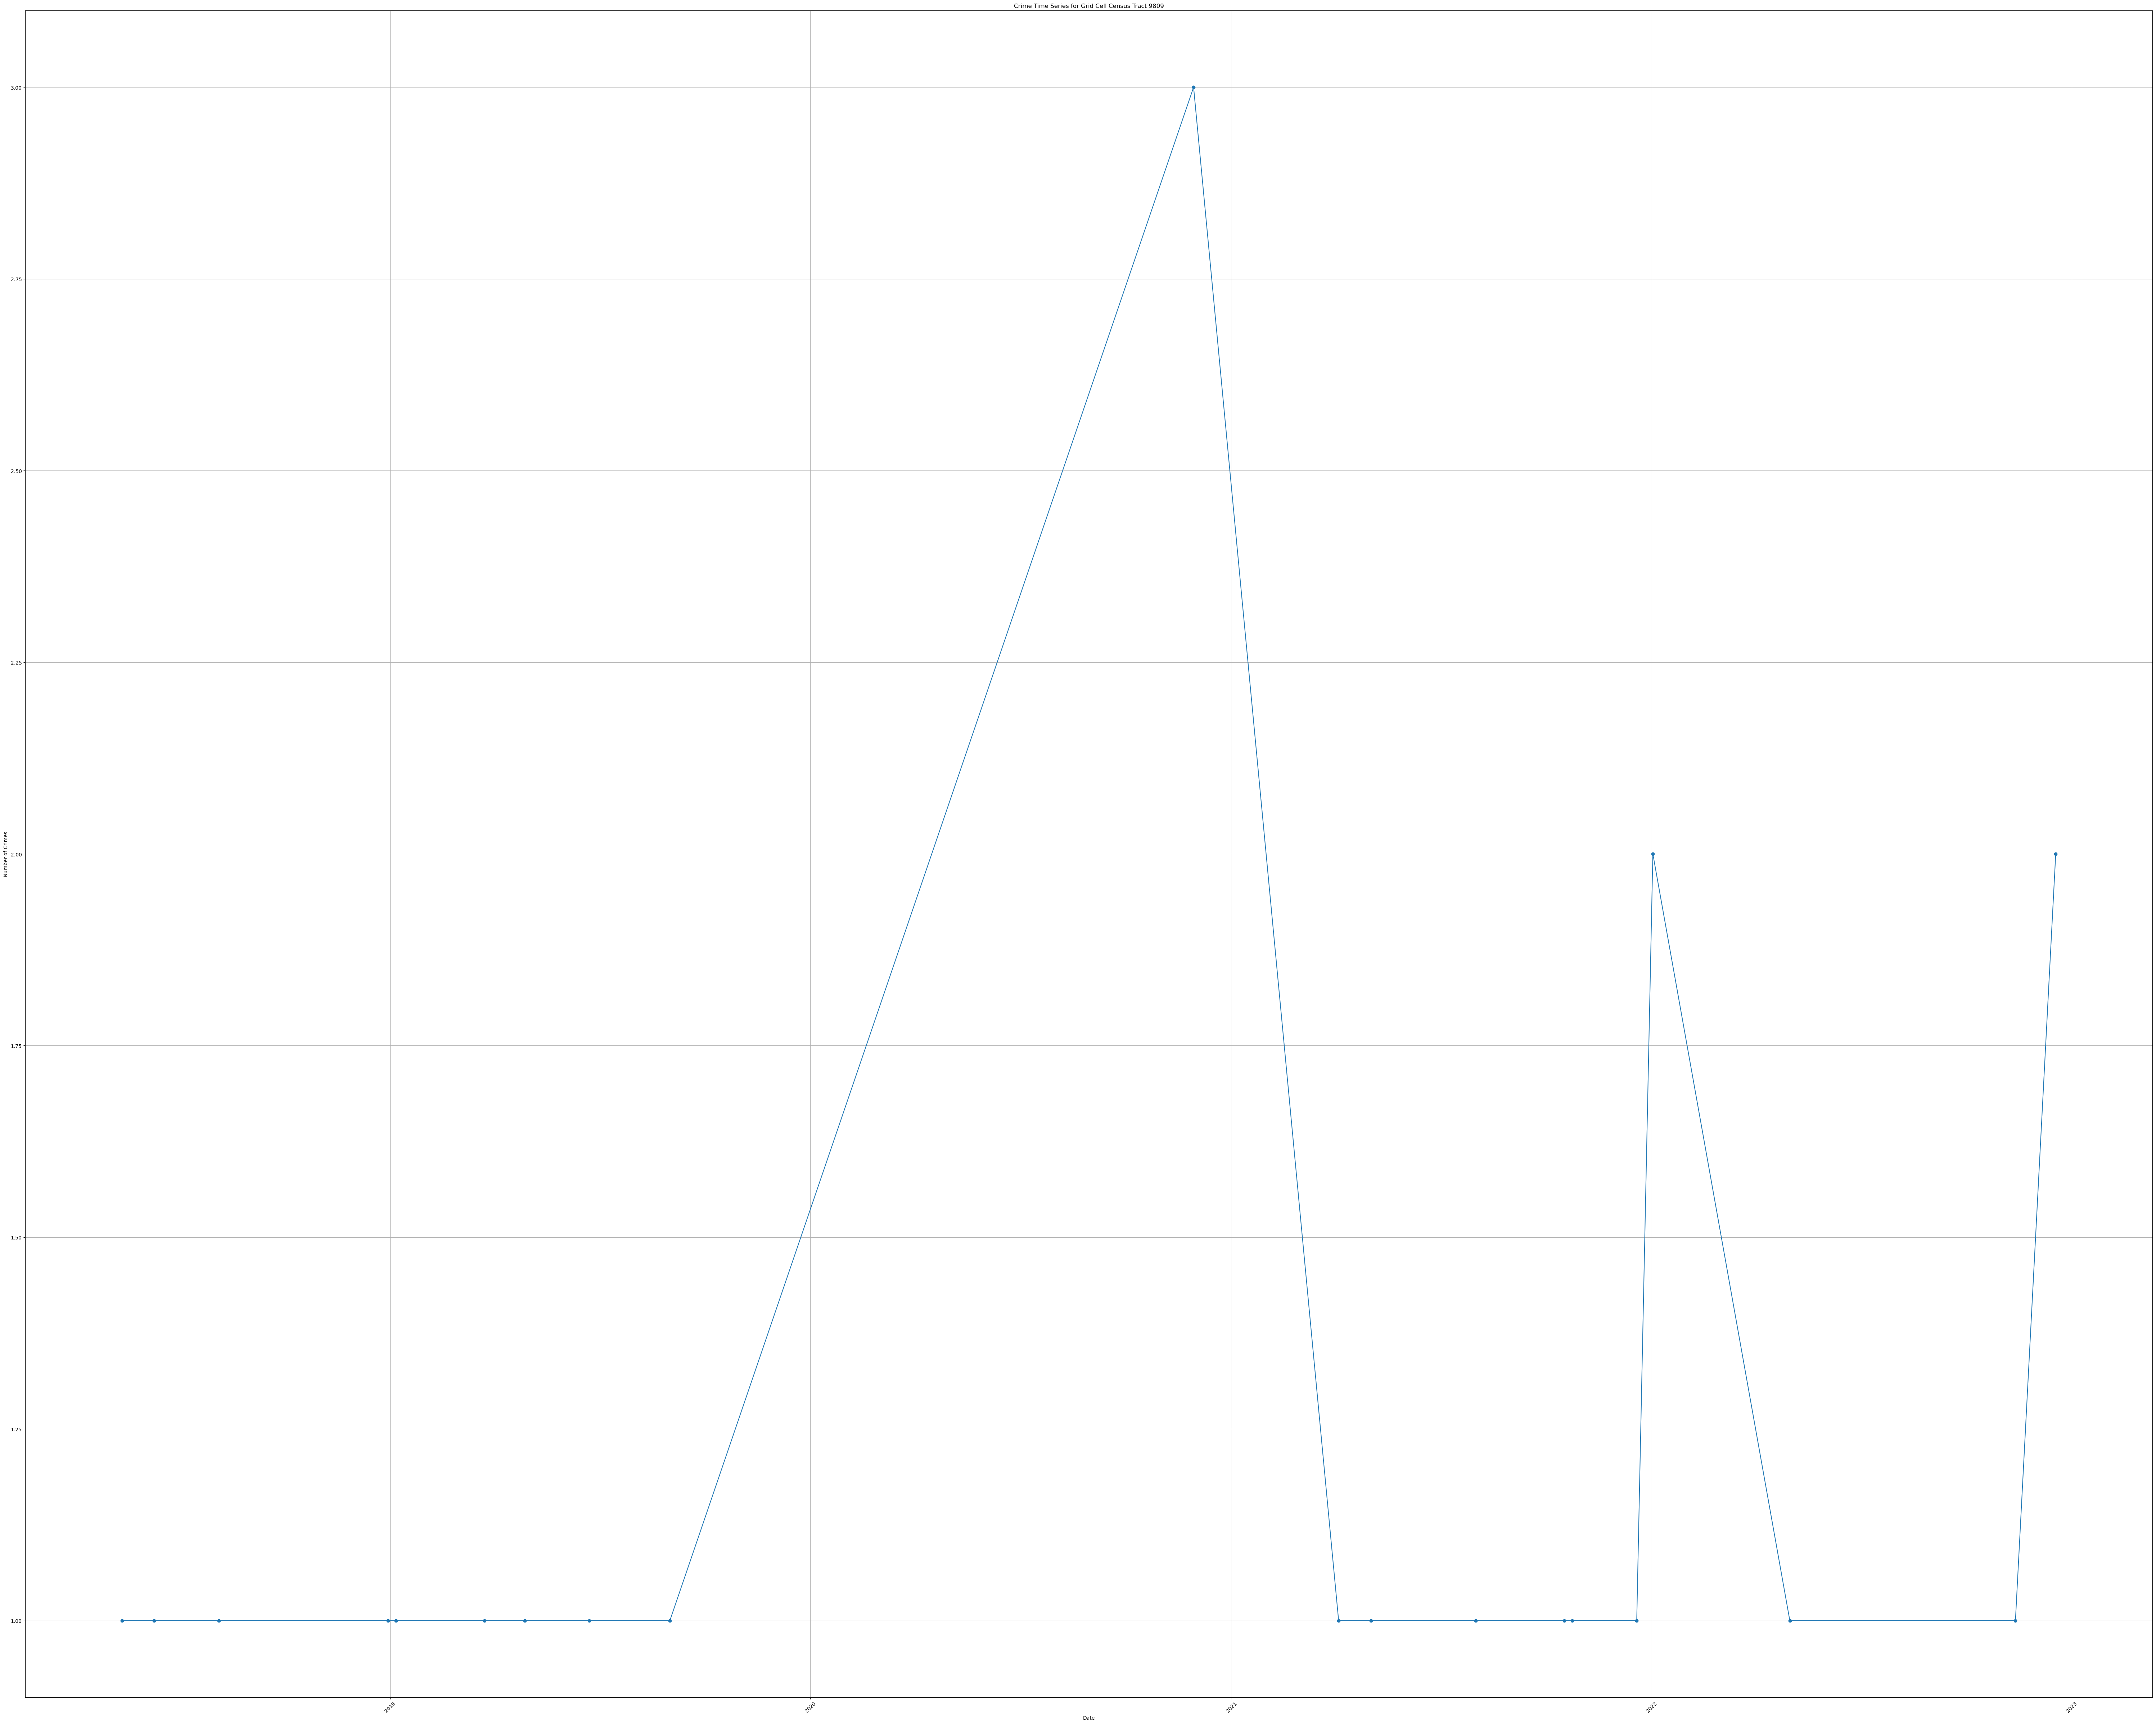

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter data for a specific CENSUS_TRACT, e.g., (x, y)
tract = 'Census Tract 9809'
time_series_data = crime_time_series[crime_time_series['CENSUS_TRACT'] == tract]

# Plot the time series for that CENSUS_TRACT
plt.figure(figsize=(60, 48))
plt.plot(time_series_data['OffenseDate'], time_series_data['Crime_Count_W'], marker='o')
plt.title(f'Crime Time Series for Grid Cell {tract}')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')

plt.xticks(rotation=45)

plt.grid(True)

plt.tight_layout()

plt.show()

In [9]:
!pip install xgboost

In [10]:
# feature encode CENSUS_TRACT
from sklearn.preprocessing import LabelEncoder

crime_time_series['CENSUS_TRACT'] = crime_time_series['CENSUS_TRACT'].apply(lambda x: str(x))

le = LabelEncoder()
crime_time_series['CENSUS_TRACT'] = le.fit_transform(crime_time_series['CENSUS_TRACT'])

In [11]:
census_tract_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Print the mappings
print("CENSUS_TRACT to Encoded Label Mappings:")
for original, encoded in census_tract_mapping.items():
    print(f"{original} -> {encoded}")

CENSUS_TRACT to Encoded Label Mappings:
Census Tract 1011.01 -> 0
Census Tract 1011.02 -> 1
Census Tract 1012.01 -> 2
Census Tract 1013 -> 3
Census Tract 1014 -> 4
Census Tract 1015.01 -> 5
Census Tract 1016.03 -> 6
Census Tract 1017 -> 7
Census Tract 1018 -> 8
Census Tract 1019.01 -> 9
Census Tract 1021.01 -> 10
Census Tract 1021.02 -> 11
Census Tract 1022 -> 12
Census Tract 1023 -> 13
Census Tract 1024.01 -> 14
Census Tract 1024.02 -> 15
Census Tract 1027 -> 16
Census Tract 1028 -> 17
Census Tract 1029 -> 18
Census Tract 1033 -> 19
Census Tract 1035 -> 20
Census Tract 1036.02 -> 21
Census Tract 1038 -> 22
Census Tract 1044 -> 23
Census Tract 1048 -> 24
Census Tract 1051 -> 25
Census Tract 1053 -> 26
Census Tract 1054 -> 27
Census Tract 1055 -> 28
Census Tract 1056.02 -> 29
Census Tract 1057 -> 30
Census Tract 1059 -> 31
Census Tract 1061 -> 32
Census Tract 1062 -> 33
Census Tract 1065 -> 34
Census Tract 1066 -> 35
Census Tract 1068 -> 36
Census Tract 1069 -> 37
Census Tract 1070 -> 3

In [12]:
crime_time_series.columns

Index(['CENSUS_TRACT', 'OffenseDate', 'DOW', 'HourofDay', 'ExtractedMonth',
       'ExtractedDay', 'Crime_Count_W'],
      dtype='object')

In [13]:
from sklearn.model_selection import train_test_split

features = ['DOW', 'HourofDay', 'ExtractedMonth', 'ExtractedDay', 'CENSUS_TRACT']

X = crime_time_series[features]
y = crime_time_series['Crime_Count_W']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

          Feature  Importance
0             DOW    0.534705
1       HourofDay    0.199790
4    CENSUS_TRACT    0.105842
3    ExtractedDay    0.103917
2  ExtractedMonth    0.055745
Mean Absolute Error: 0.9436877732336766
Root Mean Squared Error: 1.466479619209906
R² Score: 0.6508511538901451


C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


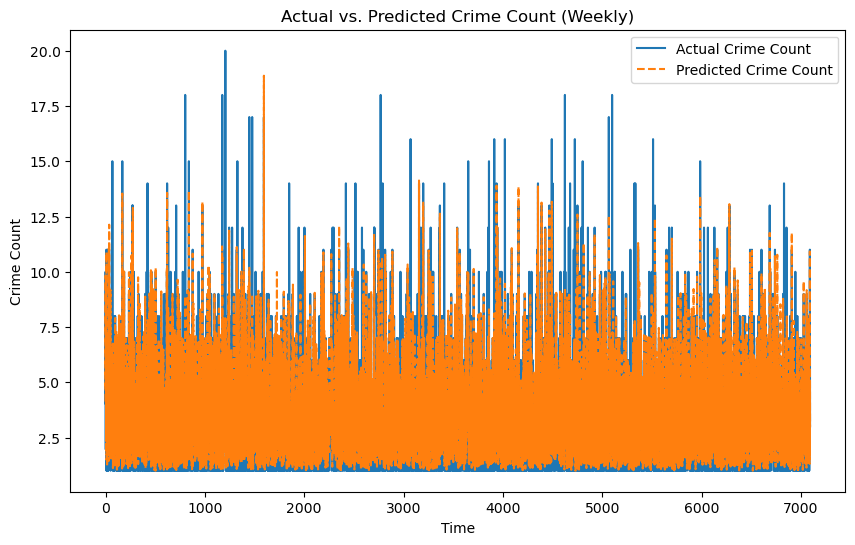

In [14]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Crime Count')
plt.plot(y_pred, label='Predicted Crime Count', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Crime Count (Weekly)')
plt.xlabel('Time')
plt.ylabel('Crime Count')
plt.show()

Mean Absolute Error: 1.0806902433745431
Root Mean Squared Error: 1.595472190831407
R² Score: 0.5867270231246948


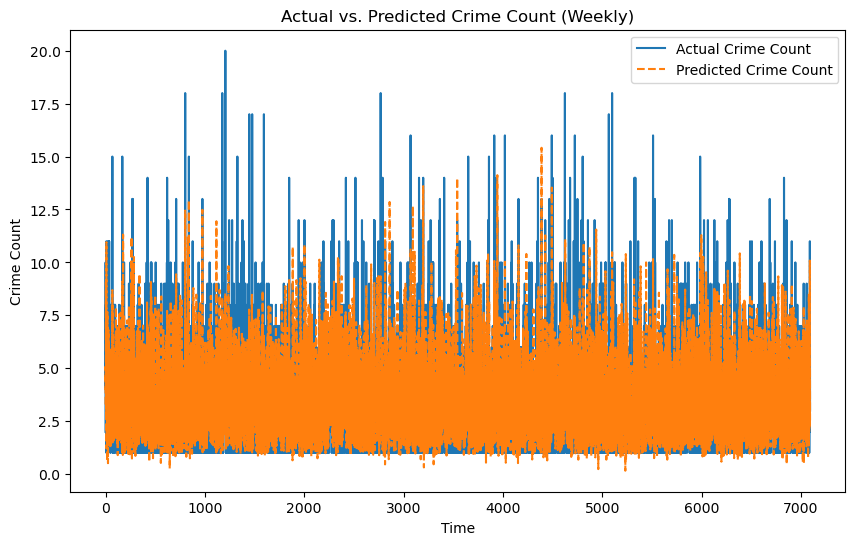

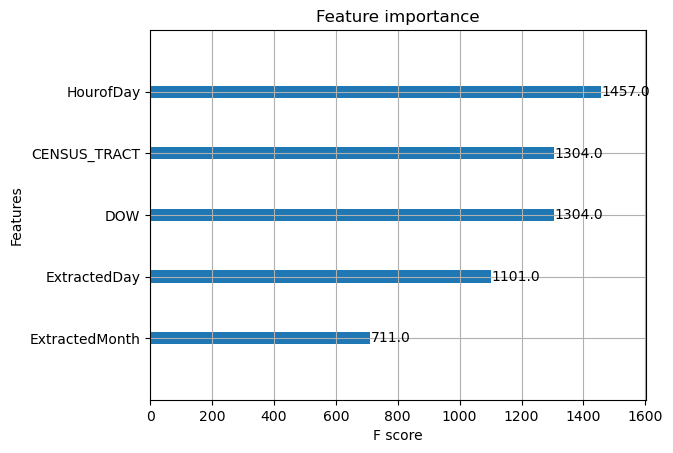

In [15]:
# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Crime Count')
plt.plot(y_pred, label='Predicted Crime Count', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Crime Count (Weekly)')
plt.xlabel('Time')
plt.ylabel('Crime Count')
plt.show()

xgb.plot_importance(xgb_model)
plt.show()

In [16]:
# Step 3: Now group by 'CENSUS_TRACT' and resample using the 'OffenseDate' index
crime_time_series = crime.groupby(['CENSUS_TRACT', pd.Grouper(freq='D')]).agg({
    'DOW': 'first',  
    'HourofDay': 'first',
    'ExtractedMonth': 'first',
    'ExtractedDay': 'first',
}).reset_index()

# Step 4: Create the 'Crime_Count' feature based on size (count of crimes)
crime_time_series['Crime_Count_D'] = crime.groupby(['CENSUS_TRACT', pd.Grouper(freq='D')]).size().values

# Now the 'crime_time_series' contains the aggregated features and 'Crime_Count'
crime_time_series

,CENSUS_TRACT,OffenseDate,DOW,HourofDay,ExtractedMonth,ExtractedDay,Crime_Count_D
0,Census Tract 1011.01,2018-01-01,2,0,1,1,1
1,Census Tract 1011.01,2018-01-12,6,14,1,12,1
2,Census Tract 1011.01,2018-01-21,1,2,1,21,1
3,Census Tract 1011.01,2018-02-03,7,10,2,3,3
4,Census Tract 1011.01,2018-02-05,2,16,2,5,1
...,...,...,...,...,...,...,...
86091,Census Tract 9809,2021-12-30,5,0,12,30,2
86092,Census Tract 9809,2022-05-01,1,18,5,1,1
86093,Census Tract 9809,2022-11-08,3,11,11,8,1
86094,Census Tract 9809,2022-12-14,4,9,12,14,1


In [17]:
# feature encode CENSUS_TRACT
from sklearn.preprocessing import LabelEncoder

crime_time_series['CENSUS_TRACT'] = crime_time_series['CENSUS_TRACT'].apply(lambda x: str(x))

le = LabelEncoder()
crime_time_series['CENSUS_TRACT'] = le.fit_transform(crime_time_series['CENSUS_TRACT'])

In [18]:
from sklearn.model_selection import train_test_split

features = ['DOW', 'HourofDay', 'ExtractedMonth', 'ExtractedDay', 'CENSUS_TRACT']

X = crime_time_series[features]
y = crime_time_series['Crime_Count_D']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

          Feature  Importance
3    ExtractedDay    0.278085
4    CENSUS_TRACT    0.231328
1       HourofDay    0.221559
0             DOW    0.142045
2  ExtractedMonth    0.126983
Mean Absolute Error: 0.6615272938443671
Root Mean Squared Error: 0.8587829150827905
R² Score: -0.08426132774874118


C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


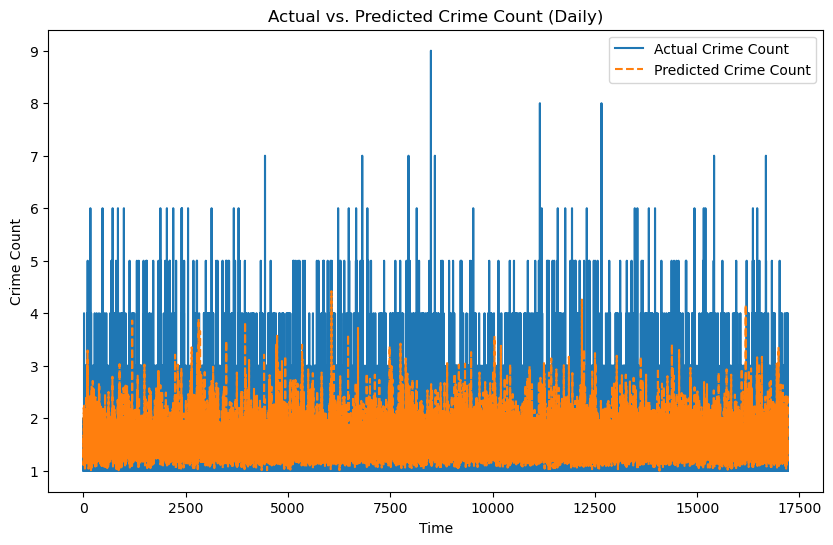

In [19]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Crime Count')
plt.plot(y_pred, label='Predicted Crime Count', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Crime Count (Daily)')
plt.xlabel('Time')
plt.ylabel('Crime Count')
plt.show()

Mean Absolute Error: 0.6253183125688085
Root Mean Squared Error: 0.8215612480297471
R² Score: 0.007690787315368652


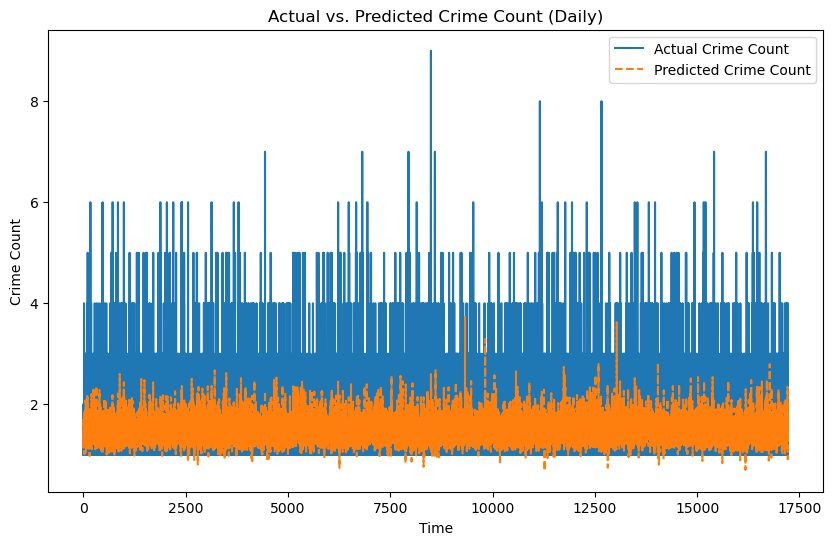

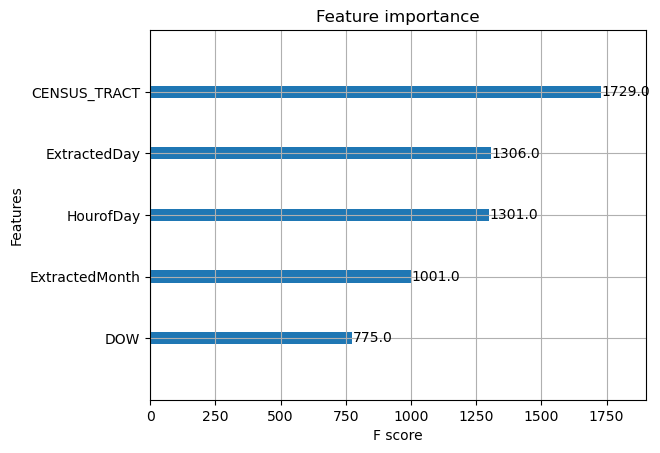

In [20]:
# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Crime Count')
plt.plot(y_pred, label='Predicted Crime Count', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Crime Count (Daily)')
plt.xlabel('Time')
plt.ylabel('Crime Count')
plt.show()

xgb.plot_importance(xgb_model)
plt.show()